# Направите модел класификације: Укусна азијска и индијска јела


## Класификатори кухиња 1

У овом часу, истражићемо различите класификаторе како бисмо *предвидели одређену националну кухињу на основу групе састојака.* Док то радимо, научићемо више о начинима на које алгоритми могу бити коришћени за задатке класификације.

### [**Квиз пре предавања**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Припрема**

Овај час се надовезује на наш [претходни час](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) где смо:

-   Направили лаган увод у класификације користећи скуп података о свим сјајним кухињама Азије и Индије 😋.

-   Истражили неке [dplyr глаголе](https://dplyr.tidyverse.org/) за припрему и чишћење наших података.

-   Направили прелепе визуализације користећи ggplot2.

-   Демонстрирали како се носити са неуравнотеженим подацима кроз њихову претходну обраду користећи [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Показали како да `prep` и `bake` наш рецепт како бисмо потврдили да ће функционисати како је предвиђено.

#### **Предуслов**

За овај час, биће нам потребни следећи пакети за чишћење, припрему и визуализацију наших података:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) је [колекција R пакета](https://www.tidyverse.org/packages) дизајнирана да учини науку о подацима бржом, лакшом и забавнијом!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) оквир је [колекција пакета](https://www.tidymodels.org/packages/) за моделирање и машинско учење.

-   `themis`: [themis пакет](https://themis.tidymodels.org/) пружа додатне кораке за рецепте за рад са неуравнотеженим подацима.

-   `nnet`: [nnet пакет](https://cran.r-project.org/web/packages/nnet/nnet.pdf) пружа функције за процену неуронских мрежа са једним скривеним слојем, као и за моделе мултиномијалне логистичке регресије.

Можете их инсталирати као:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Алтернативно, следећи скрипт проверава да ли имате пакете који су потребни за завршетак овог модула и инсталира их уколико недостају.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Поделите податке на сетове за обуку и тестирање.

Почећемо са неколико корака из нашег претходног часа.

### Избаците најчешће састојке који стварају забуну између различитих кухиња, користећи `dplyr::select()`.

Сви воле пиринач, бели лук и ђумбир!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


Савршено! Сада је време да поделимо податке тако да 70% података иде за тренинг, а 30% за тестирање. Такође ћемо применити технику `стратификације` приликом дељења података како бисмо `задржали пропорцију сваке кухиње` у тренинг и валидационим сетовима података.

[rsample](https://rsample.tidymodels.org/), пакет у оквиру Tidymodels-а, пружа инфраструктуру за ефикасно дељење и ресемплинг података:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. Рад са неуравнотеженим подацима

Као што сте можда приметили у оригиналном скупу података, као и у нашем скупу за обуку, постоји прилично неједнака расподела броја кухиња. Корејске кухиње су *готово* три пута бројније од тајландских кухиња. Неуравнотежени подаци често имају негативан утицај на перформансе модела. Многи модели најбоље функционишу када је број посматрања једнак и, самим тим, имају потешкоћа са неуравнотеженим подацима.

Постоје два главна начина за рад са неуравнотеженим скуповима података:

-   додавање посматрања мањинској класи: `Прекомерно узорковање` (Over-sampling), на пример, коришћењем SMOTE алгоритма који синтетички генерише нове примере мањинске класе користећи најближе суседе тих случајева.

-   уклањање посматрања из већинске класе: `Потцењивање узорка` (Under-sampling)

У нашем претходном часу, демонстрирали смо како се ради са неуравнотеженим скуповима података користећи `recipe`. Рецепт се може сматрати као план који описује које кораке треба применити на скуп података како би био спреман за анализу. У нашем случају, желимо да имамо једнаку расподелу броја наших кухиња за наш `скуп за обуку`. Хајде да почнемо.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Можете, наравно, да потврдите (коришћењем prep+bake) да ће рецепт функционисати како очекујете - сви ознаке кухиње имају `559` посматрања.

Пошто ћемо користити овај рецепт као претпроцесор за моделирање, `workflow()` ће обавити сав припремни и завршни посао за нас, тако да нећемо морати ручно да процењујемо рецепт.

Сада смо спремни да обучимо модел 👩‍💻👨‍💻!

## 3. Избор класификатора

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Илустрација од @allison_horst</figcaption>


Сада морамо да одлучимо који алгоритам да користимо за овај задатак 🤔.

У оквиру Tidymodels-а, [`parsnip пакет`](https://parsnip.tidymodels.org/index.html) пружа конзистентан интерфејс за рад са моделима кроз различите механизме (пакете). Погледајте документацију за parsnip како бисте истражили [типове модела и механизме](https://www.tidymodels.org/find/parsnip/#models) и њихове одговарајуће [аргументе модела](https://www.tidymodels.org/find/parsnip/#model-args). Разноврсност може изгледати прилично збуњујуће на први поглед. На пример, следеће методе укључују технике класификације:

-   C5.0 модели класификације засновани на правилима

-   Флексибилни дискриминантни модели

-   Линеарни дискриминантни модели

-   Регуларизовани дискриминантни модели

-   Модели логистичке регресије

-   Модели мултиномијалне регресије

-   Модели наивног Бајеса

-   Машине за подршку векторима

-   Најближи суседи

-   Дрвеће одлуке

-   Методе ансамбла

-   Неуронске мреже

Списак се наставља!

### **Који класификатор одабрати?**

Па, који класификатор треба да изаберете? Често је тестирање неколико њих и тражење доброг резултата начин да се испроба.

> AutoML решава овај проблем елегантно тако што врши ове поређења у облаку, омогућавајући вам да изаберете најбољи алгоритам за ваше податке. Пробајте [овде](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Такође, избор класификатора зависи од нашег проблема. На пример, када се исход може категоризовати у `више од две класе`, као у нашем случају, морамо користити `алгоритам за мултикласну класификацију` уместо `бинарне класификације.`

### **Бољи приступ**

Бољи начин од насумичног погађања је да следите идеје из овог преузимљивог [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Овде откривамо да, за наш мултикласни проблем, имамо неке опције:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Део Microsoft-овог Cheat Sheet-а за алгоритме, који приказује опције за мултикласну класификацију</figcaption>


### **Размишљање**

Хајде да видимо како можемо да приступимо проблему узимајући у обзир ограничења која имамо:

-   **Дубоке неуронске мреже су превише захтевне**. С обзиром на наш чист, али минималан скуп података, и чињеницу да обуку изводимо локално преко нотебука, дубоке неуронске мреже су превише захтевне за овај задатак.

-   **Нема класификатора са две класе**. Не користимо класификатор са две класе, што искључује приступ један-наспрам-свих.

-   **Дрво одлуке или логистичка регресија би могли да функционишу**. Дрво одлуке би могло да ради, или мултиномијална регресија/логистичка регресија за више класа.

-   **Дрво одлуке са више класа и побољшањем решава другачији проблем**. Дрво одлуке са више класа и побољшањем је најпогодније за непараметарске задатке, нпр. задатке који су дизајнирани за креирање рангирања, тако да нам није корисно.

Такође, обично је добра идеја да се пре него што се крене са сложенијим моделима машинског учења, као што су ансамбл методе, изгради најједноставнији могући модел како би се стекла идеја о томе шта се дешава. Зато ћемо у овој лекцији почети са моделом `мултиномијалне регресије`.

> Логистичка регресија је техника која се користи када је излазна променљива категоријална (или номинална). За бинарну логистичку регресију број излазних променљивих је два, док је број излазних променљивих за мултиномијалну логистичку регресију више од два. Погледајте [Напредне методе регресије](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) за додатно читање.

## 4. Обучите и процените модел мултиномијалне логистичке регресије.

У Tidymodels-у, `parsnip::multinom_reg()`, дефинише модел који користи линеарне предикторе за предвиђање података са више класа користећи мултиномијалну дистрибуцију. Погледајте `?multinom_reg()` за различите начине/моторе које можете користити за обуку овог модела.

За овај пример, обучићемо модел мултиномијалне регресије преко подразумеваног [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) мотора.

> Изабрао сам вредност за `penalty` прилично насумично. Постоје бољи начини за избор ове вредности, као што је коришћење `ресемплинг`-а и `тјунинг`-а модела, о чему ћемо говорити касније.
>
> Погледајте [Tidymodels: Почетак](https://www.tidymodels.org/start/tuning/) ако желите да научите више о томе како да подесите хиперпараметре модела.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Одличан посао 🥳! Сада када имамо рецепт и спецификацију модела, потребно је да пронађемо начин да их спојимо у један објекат који ће прво обрадити податке, затим применити модел на обрађене податке, а такође омогућити потенцијалне активности након обраде. У Tidymodels-у, овај практични објекат се назива [`workflow`](https://workflows.tidymodels.org/) и згодно чува ваше компоненте за моделирање! Ово је оно што бисмо у *Python*-у назвали *pipelines*.

Хајде да све спакујемо у workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Воркфлови 👌👌! **`workflow()`** може се прилагодити на сличан начин као и модел. Дакле, време је да обучимо модел!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Излаз приказује коефицијенте које је модел научио током обуке.

### Процена обученог модела

Време је да видимо како се модел показао 📏 процењујући га на тестном скупу! Хајде да почнемо са прављењем предвиђања на тестном скупу.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


Одличан посао! У Tidymodels-у, процена перформанси модела може се обавити коришћењем [yardstick](https://yardstick.tidymodels.org/) - пакета који се користи за мерење ефикасности модела помоћу метрика перформанси. Као што смо радили у нашој лекцији о логистичкој регресији, хајде да почнемо израчунавањем матрице конфузије.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Када се ради са више класа, генерално је интуитивније ово визуализовати као топлотну мапу, овако:


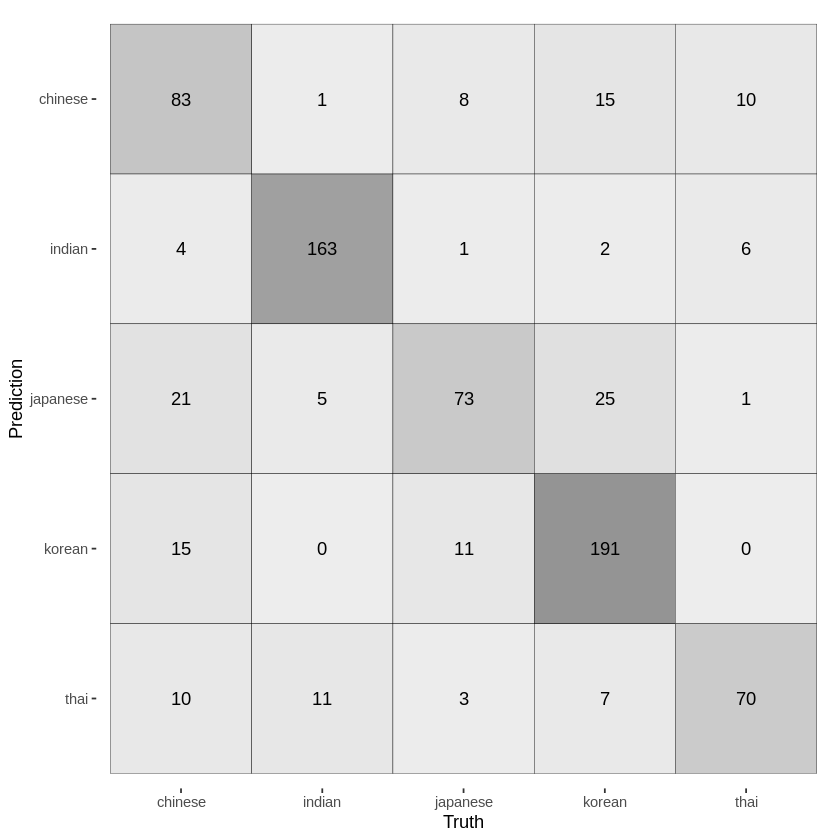

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Тамнији квадрати на графикону матрице конфузије указују на велики број случајева, и надамо се да можете видети дијагоналну линију тамнијих квадрата која указује на случајеве где су предвиђена и стварна ознака исте.

Сада ћемо израчунати резиме статистике за матрицу конфузије.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


Ако се фокусирамо на неке метрике као што су тачност, сензитивност, ppv, нисмо лоше започели 🥳!

## 4. Дубље истраживање

Хајде да поставимо једно суптилно питање: Који критеријум се користи да се одреди одређени тип кухиње као предвиђени исход?

Па, статистички алгоритми машинског учења, као што је логистичка регресија, засновани су на `вероватноћи`; дакле, оно што класификатор заправо предвиђа је расподела вероватноће за скуп могућих исхода. Класа са највишом вероватноћом се затим бира као највероватнији исход за дате опсервације.

Хајде да видимо како ово функционише тако што ћемо направити и тврде предвиђања класе и вероватноће.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


✅ Можете ли да објасните зашто је модел прилично сигуран да је прва опсервација тајландска?

## **🚀Изазов**

У овом лекцији, користили сте своје очишћене податке да изградите модел машинског учења који може да предвиди националну кухињу на основу серије састојака. Одвојите мало времена да прочитате [многе опције](https://www.tidymodels.org/find/parsnip/#models) које Tidymodels пружа за класификацију података и [друге начине](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) за примену мултинационалне регресије.

#### ХВАЛА:

[`Елисон Хорст`](https://twitter.com/allison_horst/) за креирање невероватних илустрација које чине R приступачнијим и занимљивијим. Пронађите више илустрација у њеној [галерији](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Каси Бревиу](https://www.twitter.com/cassieview) и [Џен Лупер](https://www.twitter.com/jenlooper) за креирање оригиналне Python верзије овог модула ♥️

<br>
Додао бих неке шале, али не разумем баш добро игре речи о храни 😅.

<br>

Срећно учење,

[Ерик](https://twitter.com/ericntay), Златни амбасадор за Microsoft Learn студенте.



---

**Одрицање од одговорности**:  
Овај документ је преведен коришћењем услуге за превођење помоћу вештачке интелигенције [Co-op Translator](https://github.com/Azure/co-op-translator). Иако настојимо да обезбедимо тачност, молимо вас да имате у виду да аутоматизовани преводи могу садржати грешке или нетачности. Оригинални документ на изворном језику треба сматрати ауторитативним извором. За критичне информације препоручује се професионални превод од стране људи. Не сносимо одговорност за било каква погрешна тумачења или неспоразуме који могу произаћи из коришћења овог превода.
